In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
dataset_path ="D:\dataset\Leaf\Corn"

In [5]:
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32
)

Found 4587 files belonging to 4 classes.


In [6]:
class_name = dataset.class_names
class_name

['Corn__common_rust',
 'Corn__gray_leaf_spot',
 'Corn__healthy',
 'Corn__northern_leaf_blight']

In [7]:
len(dataset)

144

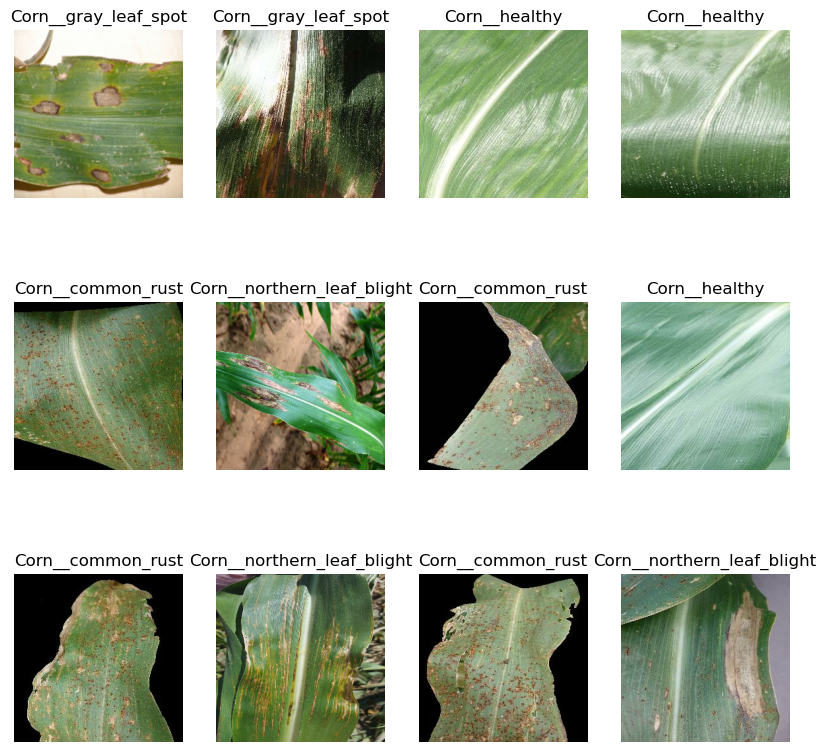

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range (12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [9]:
train_data = dataset.take(115)
len(train_data)

115

In [10]:
test_data = dataset.skip(115)
len(test_data)

29

In [12]:
validation_dataset = test_data.take(11)
len(validation_dataset)

11

In [13]:
test_data = test_data.skip(11)
len(test_data)

18

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shffle=True , shuffle_size=1000 ):
    
    ds_size = len(ds)
    
    if shffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_data = ds.take(train_size)    
    validation_dataset = ds.skip(train_size).take(val_size)
    test_data = ds.skip(train_size).skip(val_size)
    
    return train_data,validation_dataset,test_data

In [15]:
train_data,validation_dataset,test_data = get_dataset_partitions_tf(dataset)

In [17]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,  # Add data augmentation here
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_data,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    verbose=1,
    epochs=50,
)

Epoch 1/50
115/115 [==============================] - 210s 2s/step - loss: 0.8782 - accuracy: 0.5980 - val_loss: 0.7074 - val_accuracy: 0.7277
Epoch 2/50
115/115 [==============================] - 172s 1s/step - loss: 0.5963 - accuracy: 0.7308 - val_loss: 0.5822 - val_accuracy: 0.7388
Epoch 3/50
115/115 [==============================] - 171s 1s/step - loss: 0.5065 - accuracy: 0.7609 - val_loss: 0.5628 - val_accuracy: 0.7344
Epoch 4/50
115/115 [==============================] - 168s 1s/step - loss: 0.5078 - accuracy: 0.7712 - val_loss: 0.5336 - val_accuracy: 0.7946
Epoch 5/50
115/115 [==============================] - 167s 1s/step - loss: 0.4717 - accuracy: 0.7838 - val_loss: 0.3995 - val_accuracy: 0.8281
Epoch 6/50
115/115 [==============================] - 167s 1s/step - loss: 0.4906 - accuracy: 0.7767 - val_loss: 0.3900 - val_accuracy: 0.8259
Epoch 7/50
115/115 [==============================] - 165s 1s/step - loss: 0.4516 - accuracy: 0.8040 - val_loss: 0.4772 - val_accuracy: 0.7723

In [25]:
scores = model.evaluate(test_data)

15/15 [==============================] - 30s 305ms/step - loss: 0.2122 - accuracy: 0.9250


In [40]:
model.save("./Model/Corn") 

INFO:tensorflow:Assets written to: ./Model/Corn\assets


INFO:tensorflow:Assets written to: ./Model/Corn\assets


In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

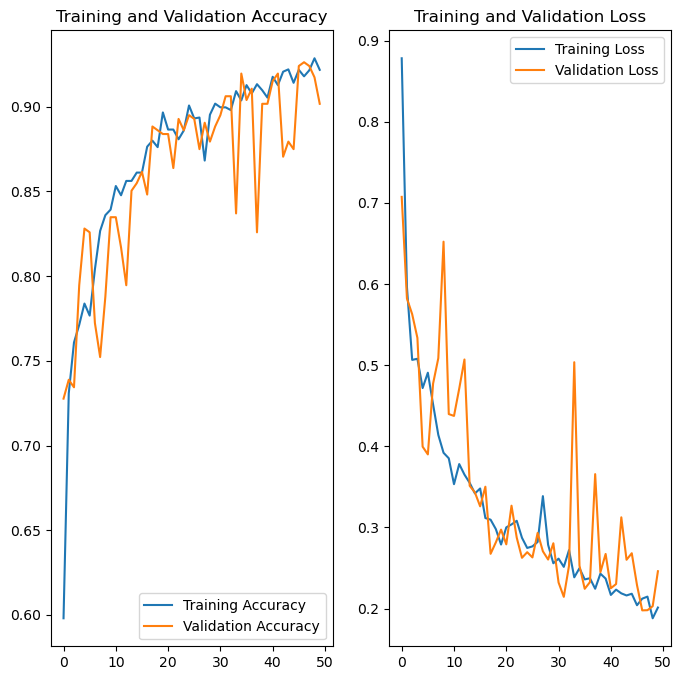

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


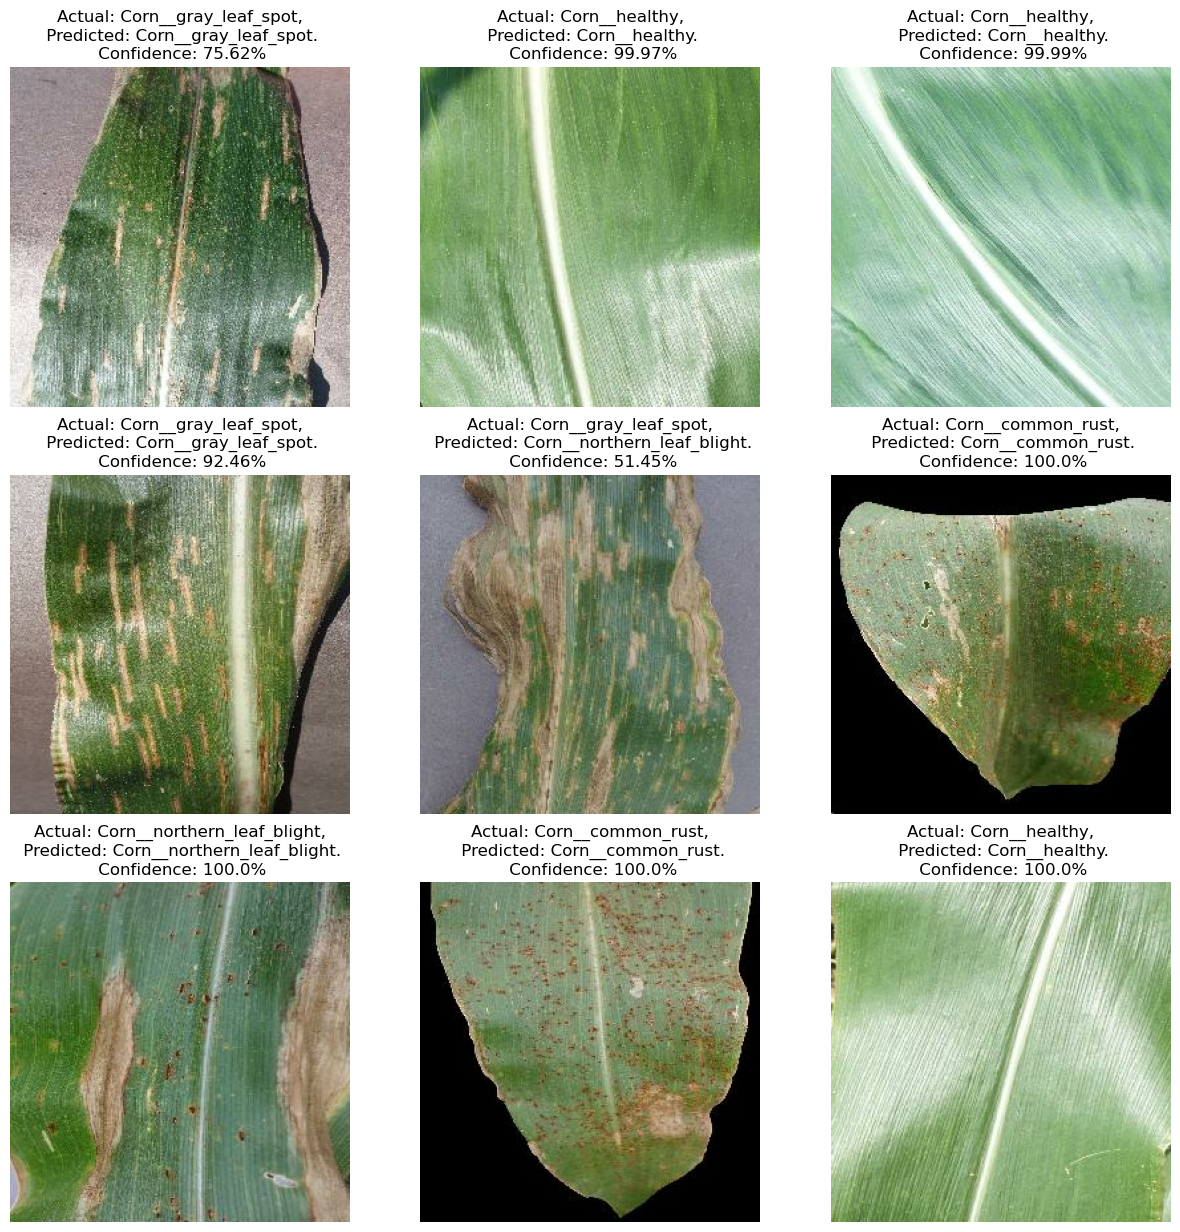

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")